In [1]:
import sys, os, time, datetime, h5py, json, glob
import numpy as np
import ROOT
from scipy.stats import norm, expon, chi2, uniform, chisquare, poisson

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib.font_manager as font_manager
plt.rcParams["font.family"] = "serif"
plt.style.use('classic')
#import getpass
# open access to cernbox
#os.system("echo %s| kinit" %getpass.getpass())

Welcome to JupyROOT 6.30/04


In [2]:
def Zscore(t_H0, t_H1):
    Z_H1 = []
    for i in t_H1:
        if np.sum(1.*(t_H0>i))>0:
            Z_H1.append(norm.ppf(1-np.sum(1.*(t_H0>i))*1./len(t_H0)))
        else:
            Z_H1.append(norm.ppf(1-1./len(t_H0)))
    return np.array(Z_H1)

def Zscore_chi2(t,df):
    sf = chi2.sf(t, df)
    Z  = -norm.ppf(sf)
    return Z

def Zscore_norm(t,loc,scale):
    sf = norm.sf(t, loc, scale)
    Z  = -norm.ppf(sf)
    return Z

def Zscore_from_pval(pval):
    return norm.ppf(1-pval)

def Zscore_empirical(t_H0, t_H1):
    Z_H1 = []
    for i in t_H1:
        if np.sum(1.*(t_H0>i))>0:
            Z_H1.append(norm.ppf(1-np.sum(1.*(t_H0>i))*1./len(t_H0)))
        else:
            Z_H1.append(norm.ppf(1-1./len(t_H0)))
    return np.array(Z_H1)

def efficiency_root(t, thr):
    nbins = len(thr)*20
    xmin = np.min(thr)
    xmax = np.max(thr)
    pEff = ROOT.TEfficiency("eff","my efficiency;x;#epsilon",nbins,xmin,xmax)
    for i in range(len(t)):
        for j in range(len(thr)):
            bPassed = t[i]>thr[j]
            pEff.Fill(bPassed,thr[j])
    alpha     = np.array([pEff.GetEfficiency(i) for i in range(nbins)])
    alpha_edw = np.array([pEff.GetEfficiencyErrorLow(i) for i in range(nbins)])
    alpha_eup = np.array([pEff.GetEfficiencyErrorUp(i) for i in range(nbins)])
    return alpha, alpha_edw, alpha_eup, nbins

def y_from_two_points(x, x1, y1, x2, y2):
    return y1+(y2-y1)/(x2-x1)*(x-x1)

def plot_2distribution(t1, t2, df, xmin=None, xmax=None, ymax=None, nbins=10, save=False, output_path='', label1='1', label2='2', legend_title='', save_name=''):
    '''
    Plot the histogram of a test statistics sample (t) and the target chi2 distribution (df must be specified!).
    The median and the error on the median are calculated in order to calculate the median Z-score and its error.
    '''
    plt.rcParams["font.family"] = "serif"
    plt.style.use('classic')
    fig  = plt.figure(figsize=(12, 9))
    fig.patch.set_facecolor('white')
    # plot distribution histogram
    if (xmin==None or xmax==None):
        xmin = np.minimum(np.min(t1), np.min(t2))
        xmax = np.maximum(np.max(t1), np.max(t2))
        
    bins      = np.linspace(xmin, xmax, nbins+1)
    binswidth = (xmax-xmin)*1./nbins
    # t1
    label  = '%s\nsample size: %i\nmedian: %s, std: %s\n'%(label1, t1.shape[0], 
                                                           str(np.around(np.median(t1), 2)),
                                                           str(np.around(np.std(t1), 2)))
    if df:
        Z_obs     = Zscore_chi2(np.median(t1), df)
        t_obs_err = 1.2533*np.std(t1)*1./np.sqrt(t1.shape[0])
        Z_obs_p   = Zscore_chi2(np.median(t1)+t_obs_err, df)
        Z_obs_m   = Zscore_chi2(np.median(t1)-t_obs_err, df)
        label += 'asymptotic Z = %s (+%s/-%s)'%(str(np.around(Z_obs, 2)), 
                                                str(np.around(Z_obs_p-Z_obs, 2)), 
                                                str(np.around(Z_obs-Z_obs_m, 2)))
    
    h = plt.hist(t1, weights=np.ones_like(t1)*1./(t1.shape[0]*binswidth), color='lightblue', ec='#2c7fb8',
                 bins=bins, label=label)
    err = np.sqrt(h[0]/(t1.shape[0]*binswidth))
    x   = 0.5*(bins[1:]+bins[:-1])
    plt.errorbar(x, h[0], yerr = err, color='#2c7fb8', marker='o', ls='')
    max1 = np.max(h[0])
    # t2
    label  = '%s\nsample size: %i\nmedian: %s, std: %s\n'%(label2, t2.shape[0], str(np.around(np.median(t2), 2)),str(np.around(np.std(t2), 2)))
    if df:
        Z_obs     = Zscore_chi2(np.median(t2), df)
        Z_obs_16  = Zscore_chi2(np.quantile(t2, 0.16), df)
        Z_obs_84  = Zscore_chi2(np.quantile(t2, 0.84), df)
        print('16: %f, 50: %f, 84: %f'%(Z_obs_16, Z_obs, Z_obs_84))
        t_obs_err = 1.2533*np.std(t2)*1./np.sqrt(t2.shape[0])
        Z_obs_p   = Zscore_chi2(np.median(t2)+t_obs_err, df)
        Z_obs_m   = Zscore_chi2(np.median(t2)-t_obs_err, df)
        label += 'asymptotic Z = %s (+%s/-%s) \n'%(str(np.around(Z_obs, 2)), str(np.around(Z_obs_p-Z_obs, 2)), str(np.around(Z_obs-Z_obs_m, 2)))
        
    t_empirical = np.sum(1.*(t1>np.mean(t2)))*1./t1.shape[0]
    empirical_lim = '='
    if t_empirical==0:
        empirical_lim='>'
        t_empirical = 1./t1.shape[0]
    t_empirical_err = t_empirical*np.sqrt(1./np.sum(1.*(t1>np.mean(t2))+1./t1.shape[0]))
    Z_empirical = norm.ppf(1-t_empirical)
    Z_empirical_m = norm.ppf(1-(t_empirical+t_empirical_err))
    Z_empirical_p = norm.ppf(1-(t_empirical-t_empirical_err))                                      
    label += 'empirical Z %s %s (+%s/-%s)'%(empirical_lim, str(np.around(Z_empirical, 2)), str(np.around(Z_empirical_p-Z_empirical, 2)), str(np.around(Z_empirical-Z_empirical_m, 2)))
    h = plt.hist(t2, weights=np.ones_like(t2)*1./(t2.shape[0]*binswidth), color='#8dd3c7', ec='seagreen',
                 bins=bins, label=label)
    err = np.sqrt(h[0]/(t2.shape[0]*binswidth))
    x   = 0.5*(bins[1:]+bins[:-1])
    plt.errorbar(x, h[0], yerr = err, color='seagreen', marker='o', ls='')
    max2 = np.max(h[0])
    if df:
        # plot reference chi2
        x  = np.linspace(chi2.ppf(0.0001, df), chi2.ppf(0.9999, df), 100)
        plt.plot(x, chi2.pdf(x, df),'midnightblue', lw=5, alpha=0.8, label=r'$\chi^2$('+str(df)+')')
        
    font = font_manager.FontProperties(family='serif', size=18) #weight='bold', style='normal', )
    plt.legend(ncol=1, loc='best', prop=font, title=legend_title, title_fontsize=18)
    plt.xlabel(r'$t$', fontsize=26, fontname="serif")
    plt.ylabel('Probability', fontsize=26, fontname="serif")
    plt.ylim(0., 1.5*np.maximum(max1, max2))#np.max(chi2.pdf(x, df))*1.3)
    if ymax !=None:
        plt.ylim(0., ymax)
    plt.yticks(fontsize=22, fontname="serif")
    plt.xticks(fontsize=22, fontname="serif")
    if save:
        if output_path=='':
            print('argument output_path is not defined. The figure will not be saved.')
        else:
            plt.savefig(output_path+ save_name+'_2distributions.pdf')
    plt.show()
    plt.close()
    return


# Expo 1D

In [3]:

labels = [
    r"$\rm H_0$",
    r"$\rm H_1$",
    r"$\rm H_2$",
    r"$\rm H_2'$",
    r"$\rm H_3$",
    r"$\rm H_4$",
]

## NN

In [4]:
folders = [
    '/eos/user/g/ggrosso/PhD/BSM/wc8/toy/1D/Nbkg2000_Nref200000_Nsig0_epochsTau300000_epochsDelta100000_arc1_4_1_wclip8/',
    '/eos/user/g/ggrosso/PhD/BSM/wc8/toy/1D/Nbkg2000_Nref200000_Nsig10_locSig6.4_stdSig0.16_epochsTau300000_epochsDelta100000_arc1_4_1_wclip8/',
    '/eos/user/g/ggrosso/PhD/BSM/wc8/toy/1D/Nbkg2000_Nref200000_Nsig90_NP2_epochsTau300000_epochsDelta100000_arc1_4_1_wclip8/',
    '/eos/user/g/ggrosso/PhD/BSM/wc8/toy/1D/Nbkg1890_Nref200000_Nsig110_NP2_epochsTau300000_epochsDelta100000_arc1_4_1_wclip8/',
    '/eos/user/g/ggrosso/PhD/BSM/wc8/toy/1D/Nbkg2000_Nref200000_Nsig90_locSig1.6_stdSig0.16_epochsTau300000_epochsDelta100000_arc1_4_1_wclip8/',
    '/eos/user/g/ggrosso/PhD/BSM/wc8/toy/1D/Nbkg2000_Nref200000_Nsig0_maxthr5.07_epochsTau300000_epochsDelta100000_arc1_4_1_wclip8/'
]

tests_0 = {}
folder  = folders[0]
seeds_0 = []
f = h5py.File('%s/out/all_tests_thesis_v2.h5'%(folder), 'r')
labels_tests_all = list(f.keys())
for test in labels_tests_all:
    if test=='seed':
        seeds_0 = np.array(f.get(test))
        print(seeds_0.shape)
    else:
        tests_0[test] = np.array(f.get(test))
f.close()

tests = []
Zscores = []
for folder in folders:
    tests_i = {}
    Zscores_i = {}
    seeds_i = {}
    str_bkg=''
    if folder ==folders[0]:
        str_bkg=''
    f = h5py.File('%s/out/all_tests_thesis%s_v2.h5'%(folder,str_bkg), 'r')
    labels_tests_all = list(f.keys())
    for test in labels_tests_all:
        tests_i[test]   = np.array(f.get(test))
        if test=='seed': continue
        if test=='MCE' or ('RPS' in test)  :
            Zscores_i[test] = Zscore_empirical(-1*tests_0[test], -1*tests_i[test])
        elif test=='LRT':
            Zscores_i[test] = Zscore_chi2(tests_i[test], df=13)
        else:
            Zscores_i[test] = Zscore_empirical(tests_0[test], tests_i[test])
    f.close()
    tests.append(tests_i)
    Zscores.append(Zscores_i)

(314,)


## Read C2ST

In [7]:
filename_list = [
    '/eos/user/g/ggrosso/PhD/NOTEBOOKS/NPLM-GOF/1D/C2STunbalanced_seed1234_valsplit0_Sig0_Bkg1000_Ref100000_1-20-1_null.h5',
    '/eos/user/g/ggrosso/PhD/NOTEBOOKS/NPLM-GOF/1D/C2STunbalanced_seed1234_valsplit0_Sigloc6.4_Sigstd0.16_Sig5_Bkg1000_Ref100000_1-20-1_alternative.h5',
    '/eos/user/g/ggrosso/PhD/NOTEBOOKS/NPLM-GOF/1D/C2STunbalanced_seed1234_valsplit0_NP2_Sig45_Bkg1000_Ref100000_1-20-1_alternative.h5',
    '/eos/user/g/ggrosso/PhD/NOTEBOOKS/NPLM-GOF/1D/C2STunbalanced_seed1234_valsplit0_NP2_Sig55_Bkg945_Ref100000_1-20-1_alternative.h5',
    '/eos/user/g/ggrosso/PhD/NOTEBOOKS/NPLM-GOF/1D/C2STunbalanced_seed1234_valsplit0_Sigloc1.6_Sigstd0.16_Sig45_Bkg1000_Ref100000_1-20-1_alternative.h5',
    '/eos/user/g/ggrosso/PhD/NOTEBOOKS/NPLM-GOF/1D/C2STunbalanced_seed1234_valsplit0_xmax5.070000_Sig0_Bkg1094_Ref100000_1-20-1_alternative.h5'
                ]
k=0
for filename in filename_list:
    f = h5py.File(filename, 'r')
    if filename==filename_list[0]:
        tests_0['C2ST'] = np.array(f.get('balanced_accuracy'))
    tests[k]['C2ST']= np.array(f.get('balanced_accuracy'))
    f.close()
    k+=1

## Read NPLM Falkon

In [8]:
files = [
    '/eos/user/g/ggrosso/PhD/NOTEBOOKS/NPLM-GOF/Flk_1D_2/Ref.npy',
    '/eos/user/g/ggrosso/PhD/NOTEBOOKS/NPLM-GOF/Flk_1D_2/NP1_10.npy',
    '/eos/user/g/ggrosso/PhD/NOTEBOOKS/NPLM-GOF/Flk_1D_2/NP2_90.npy',
    '/eos/user/g/ggrosso/PhD/NOTEBOOKS/NPLM-GOF/Flk_1D_2/NP2_shape.npy',
    '/eos/user/g/ggrosso/PhD/NOTEBOOKS/NPLM-GOF/Flk_1D_2/NP3_90.npy',
    '/eos/user/g/ggrosso/PhD/NOTEBOOKS/NPLM-GOF/Flk_1D_2/NP4.npy',
    
]

f  = np.load(files[0])
#seeds_0 = []
labels_tests_all = ['LRT','Pois','SsqrtB5','Acc','BA','AUCext', 'KS'] #['LRT','SsqrtB5','Acc','BA','AUCext','KS']
i=0
for test in labels_tests_all:
    tests_0[test+'_flk'] = f[:, i]
    i+=1
    
ks = [0,1,2,3, 4, 5]#6,8]
j=0
for fl in files:
    f = np.load(fl)
    print(f.shape)
    i=0
    for test in labels_tests_all:
        if f.shape[1]==7:
            tests[ks[j]][test+'_flk']   = f[:, i]
        elif f.shape[1]==3 and not test in ['LRT', "Acc", "AUCext"]:
            continue
        elif test == 'LRT':
            tests[ks[j]][test+'_flk']   = f[:, 0]
        elif test == 'Acc':
            tests[ks[j]][test+'_flk']   = f[:, 1]
        elif test == 'AUCext':
            tests[ks[j]][test+'_flk']   = f[:, 2]
        if test=='MCE':
            Zscores[ks[j]][test+'_flk'] = Zscore_empirical(-1*tests_0[test+'_flk'], -1*tests[ks[j]][test+'_flk'])
            
        else:
            Zscores[ks[j]][test+'_flk'] = Zscore_empirical(tests_0[test+'_flk'], tests[ks[j]][test+'_flk'])
        i+=1
    j+=1

(1000, 7)
(300, 7)
(300, 7)
(300, 3)
(300, 7)
(300, 7)


0
1


/tmp/ipykernel_533/2543709865.py:104: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  thr = np.array([np.quantile(t0, alpha_i, interpolation='nearest') for alpha_i in alpha_ini])
/tmp/ipykernel_533/744294864.py:40: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  pEff.Fill(bPassed,thr[j])
/tmp/ipykernel_533/2543709865.py:108: RuntimeWarning: invalid value encountered in double_scalars
  Z_alpha_eup = np.array([Zscore_from_pval(alpha[i]-alpha_edw[i])-Zscore_from_pval(alpha[i]) for i in range(nbins)])


2


/tmp/ipykernel_533/2543709865.py:104: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  thr = np.array([np.quantile(t0, alpha_i, interpolation='nearest') for alpha_i in alpha_ini])
/tmp/ipykernel_533/744294864.py:40: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  pEff.Fill(bPassed,thr[j])
/tmp/ipykernel_533/2543709865.py:108: RuntimeWarning: invalid value encountered in double_scalars
  Z_alpha_eup = np.array([Zscore_from_pval(alpha[i]-alpha_edw[i])-Zscore_from_pval(alpha[i]) for i in range(nbins)])


3


/tmp/ipykernel_533/2543709865.py:104: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  thr = np.array([np.quantile(t0, alpha_i, interpolation='nearest') for alpha_i in alpha_ini])
/tmp/ipykernel_533/744294864.py:40: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  pEff.Fill(bPassed,thr[j])
/tmp/ipykernel_533/2543709865.py:108: RuntimeWarning: invalid value encountered in double_scalars
  Z_alpha_eup = np.array([Zscore_from_pval(alpha[i]-alpha_edw[i])-Zscore_from_pval(alpha[i]) for i in range(nbins)])


4


/tmp/ipykernel_533/2543709865.py:104: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  thr = np.array([np.quantile(t0, alpha_i, interpolation='nearest') for alpha_i in alpha_ini])
/tmp/ipykernel_533/744294864.py:40: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  pEff.Fill(bPassed,thr[j])
/tmp/ipykernel_533/2543709865.py:108: RuntimeWarning: invalid value encountered in double_scalars
  Z_alpha_eup = np.array([Zscore_from_pval(alpha[i]-alpha_edw[i])-Zscore_from_pval(alpha[i]) for i in range(nbins)])


5


/tmp/ipykernel_533/2543709865.py:104: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  thr = np.array([np.quantile(t0, alpha_i, interpolation='nearest') for alpha_i in alpha_ini])
/tmp/ipykernel_533/744294864.py:40: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  pEff.Fill(bPassed,thr[j])
/tmp/ipykernel_533/2543709865.py:108: RuntimeWarning: invalid value encountered in double_scalars
  Z_alpha_eup = np.array([Zscore_from_pval(alpha[i]-alpha_edw[i])-Zscore_from_pval(alpha[i]) for i in range(nbins)])


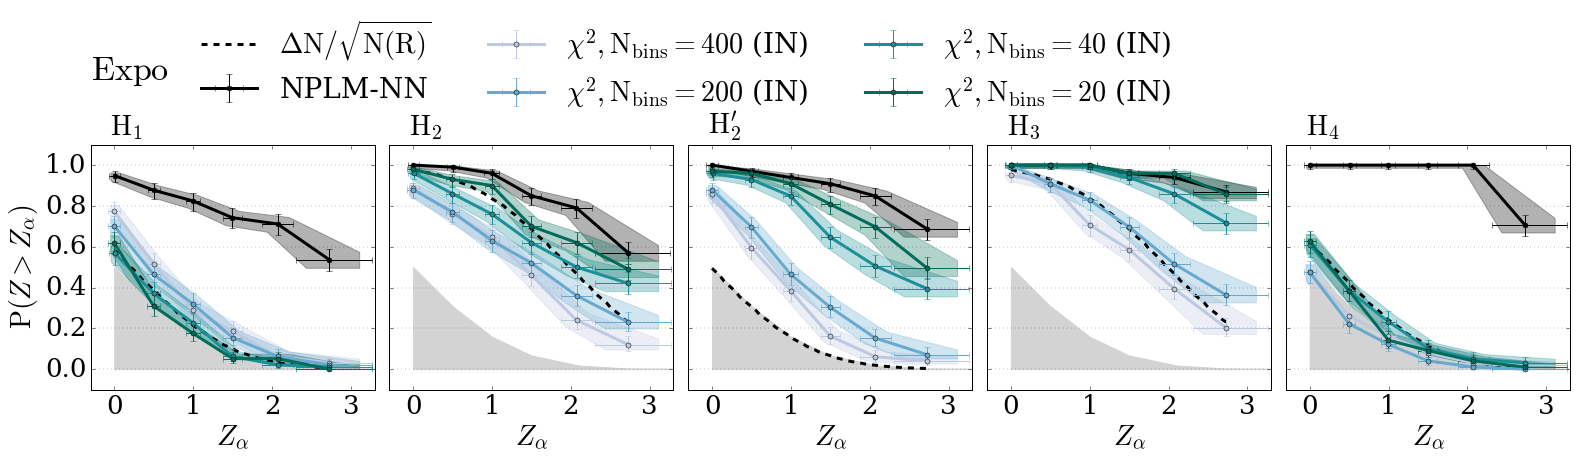

In [50]:
W = 22
H = 6
w = W/5.3
h = H/1.2
colors = ['#fff7fb','#ece2f0','#d0d1e6','#a6bddb','#67a9cf','#3690c0','#02818a','#016c59','#014636', 'black']
fig  = plt.figure(figsize=(W,H))
fig.patch.set_facecolor('white')
Z_alpha_ini = [0, 0.5, 1, 1.5, 2.1, 2.7, 4, 5]#[0,0.2, 0.5, 1, 1.2, 1.5, 1.7, 2, 2.5, 3.5, 4.5]
Z_alpha_ini = np.array(Z_alpha_ini)
alpha_ini   = [norm.cdf(i) for i in Z_alpha_ini]

data_size = [2000, 2010, 2090, 2000, 2090, 1987]
Z_alpha_pois = np.arange(0, 2.8, 0.05)
alpha_pois = norm.cdf(Z_alpha_pois)
Pois_alpha = poisson.ppf(alpha_pois, mu=2000)
Pois_alpha_5 = poisson.ppf(1-alpha_pois, mu=2000)
labels_tests_dict = {
    '1':['LRT', 'CHI2FLAT_5_IN', 'CHI2FLAT_10_IN', 'CHI2FLAT_50_IN', 'CHI2FLAT_100_IN', 'SsqrtB_tot', ],
    '2':['LRT', 'CHI2FLAT_5_OUT', 'CHI2FLAT_10_OUT', 'CHI2FLAT_50_OUT', 'CHI2FLAT_100_OUT','SsqrtB_tot',],
    '3':['LRT', 'KSin', 'CvM_v2_IN', 'AD_v2_IN', 'SsqrtB_tot', ],
    '4':['LRT', 'KSout', 'CvM_v2_OUT', 'AD_v2_OUT', 'SsqrtB_tot', ],
    '5':['LRT', 'Moran_IN', 'RPS_IN', 'SsqrtB_tot',],
    '6':['LRT', 'Moran_OUT', 'RPS_OUT', 'SsqrtB_tot', ],
    #'7':[ 'CC1', 'CC2', 'SsqrtB_tot','LRT'],
    #'8':['ACC_thr', 'CC1_thr', 'CC2_thr', 'SsqrtB_tot','LRT'],
    '9':['LRT', 'C2ST', 'SsqrtB_tot',],
    '10': ['LRT', 'ACC_fixed','ACC', 'AUC_ext', 'SsqrtB_tot',],
    '11': ['LRT_flk', 'Acc_flk', 'AUCext_flk', 'SsqrtB_tot',],
    }
color_dict ={
    '1':['black', '#bdc9e1','#67a9cf','#1c9099','#016c59', 'black', ], 
    '2':['black', '#bdc9e1','#67a9cf','#1c9099','#016c59', 'black',],
    '3':['black', '#bdc9e1','#67a9cf','#02818a', 'black', ],
    '4':['black', '#bdc9e1','#67a9cf','#02818a', 'black', ],
    '5':['black', '#67a9cf','#02818a', 'black', ],
    '6':['black', '#67a9cf','#02818a', 'black', ],
    #'7':['#67a9cf','#02818a', 'black', 'black'],
    #'8':['#bdc9e1','#1c9099','#016c59', 'black', 'black'],
    '9' :['black', '#1c9099', 'black', ],
    '10':['black', '#bdc9e1','#67a9cf','#02818a', 'black', ],
    '11':['black', '#67a9cf','#02818a', 'black',],
    }
xlabels_tests_dict  = {
    '1': ['NPLM-NN', r"$\chi^2, {\rm N_{bins}}=%i$ (IN)"%(400), r"$\chi^2, {\rm N_{bins}}=%i$ (IN)"%(200), r"$\chi^2, {\rm N_{bins}}=%i$ (IN)"%(40), r"$\chi^2, {\rm N_{bins}}=%i$ (IN)"%(20),r'${\rm \Delta N/\sqrt{N(R)}}$', ],
    '2': ['NPLM-NN', r"$\chi^2, {\rm N_{bins}}=%i$ (OUT)"%(400), r"$\chi^2, {\rm N_{bins}}=%i$ (OUT)"%(200), r"$\chi^2, {\rm N_{bins}}=%i$ (OUT)"%(40), r"$\chi^2, {\rm N_{bins}}=%i$ (OUT)"%(20), r'${\rm \Delta N/\sqrt{N(R)}}$', 'NPLM-NN'],
    '3': ['NPLM-NN', "KS (IN)", "CvM (IN)", "AD (IN)", r'${\rm \Delta N/\sqrt{N(R)}}$'],
    '4': ['NPLM-NN', "KS (OUT)", "CvM (OUT)", "AD (OUT)", r'${\rm \Delta N/\sqrt{N(R)}}$',],
    '5': ['NPLM-NN', 'Moran (IN)', 'RPS (IN)', r'${\rm \Delta N/\sqrt{N(R)}}$', ],
    '6': ['NPLM-NN', 'Moran (OUT)', 'RPS (OUT)', r'${\rm \Delta N/\sqrt{N(R)}}$', ],
    #'7': ['CC1', 'CC2', r'${\rm \Delta N/\sqrt{N(R)}}$', 'NPLM-NN'],
    #'8': ['ACC thr', 'CC1 thr', 'CC2 thr', r'${\rm \Delta N/\sqrt{N(R)}}$', 'NPLM-NN'],
    '9':  ['NPLM-NN', 'C2ST', r'${\rm \Delta N/\sqrt{N(R)}}$',],
    '10': ['NPLM-NN', r'ACC$_{1/2}$-NN', r'ACC$_{\rm max}$-NN', 'AUC-NN', r'${\rm \Delta N/\sqrt{N(R)}}$',],
    '11': ['NPLM-KM', r'ACC$_{\rm max}$-KM', 'AUC-KM', r'${\rm \Delta N/\sqrt{N(R)}}$', ],
}  

lw=3
ms=2
version = '1'
labels_tests = labels_tests_dict[version]
color = color_dict[version] 
xlabels_tests = xlabels_tests_dict[version]
i=0
for k in range(len(tests)):
    print(k)
    if k==0: continue
    ax1 = fig.add_axes([0.06+w/W*i, 0.17*h/H, w/W*0.95, h/H*0.68])
    if k==5:
        countings_power = poisson.cdf(Pois_alpha_5, mu=data_size[k])
    else:
        countings_power = poisson.sf(Pois_alpha, mu=data_size[k])
    for j in range(len(labels_tests)):
        if labels_tests[j] not in list(tests[k].keys()): continue
        t  = tests[k][labels_tests[j]]
        t0 = tests_0[labels_tests[j]]
        mask0 = (~np.isnan(t0))*(~np.isinf(t0))
        mask  = (~np.isnan(t))*(~np.isinf(t))
        t0, t = t0[mask0], t[mask]
        if labels_tests[j] == 'LRT': t0=t0[t0<np.max(t0)]
        if labels_tests[j] == 'MCE':
            t = t *-1
            t0= t0*-1
        if k==1 and 'ACC' in labels_tests[j] :
            t = t *-1
            t0= t0*-1
        if k==5 and 'ACC' in labels_tests[j] :
            t = t *-1
            t0= t0*-1
        if k==5 and 'AUC' in labels_tests[j] :
            t = t *-1
            t0= t0*-1
        if k==3 and 'Moran' in labels_tests[j] :
            t = t *-1
            t0= t0*-1
        if k==5 and 'Moran_IN' in labels_tests[j] :
            t = t *-1
            t0= t0*-1
        if k==5 and 'RPS_IN' in labels_tests[j] :
            t = t *-1
            t0= t0*-1
        if k==5 and 'CC1' in labels_tests[j] :
            t = t *-1
            t0= t0*-1
        thr = np.array([np.quantile(t0, alpha_i, interpolation='nearest') for alpha_i in alpha_ini])
        alpha, alpha_edw, alpha_eup, nbins = efficiency_root(t0, thr)
        power, power_edw, power_eup, nbins = efficiency_root(t, thr)
        Z_alpha   = np.array([Zscore_from_pval(alpha[i]) for i in range(nbins)])
        Z_alpha_eup = np.array([Zscore_from_pval(alpha[i]-alpha_edw[i])-Zscore_from_pval(alpha[i]) for i in range(nbins)])
        Z_alpha_edw = np.array([Zscore_from_pval(alpha[i])-Zscore_from_pval(alpha[i]+alpha_eup[i]) for i in range(nbins)]) 

        lb = xlabels_tests[j]

        zorder=3
        ls='-'
        if labels_tests[j]=='LRT': 
            zorder=2
            lw=3
            ms=5
        
        if labels_tests[j]=='SsqrtB_tot':
            zorder=2
            lw=3
            ms=5
            ls='--'
            x = Z_alpha_pois
            y = countings_power
            plt.plot(x, y, color=color[j], lw=lw, ls=ls, zorder=zorder, label=lb,ms=ms)
        else:
            x = Z_alpha[~np.isinf(Z_alpha)]
            y = power[~np.isinf(Z_alpha)]
            y_dw, y_up = power_edw[~np.isinf(Z_alpha)], power_eup[~np.isinf(Z_alpha)]
            x_dw, x_up = Z_alpha_edw[~np.isinf(Z_alpha)], Z_alpha_eup[~np.isinf(Z_alpha)]
            ax1.errorbar(x, y, 
                         yerr=[y_dw, y_up], 
                         xerr=[x_dw, x_up], 
                         marker='o', label=lb, color=color[j], lw=lw, ms=ms, ls=ls, elinewidth=1, zorder=zorder)
            x_fill,y_fill_dw, y_fill_up = np.array([]),np.array([]),np.array([])
            for a in range(len(x)):
                x_fill = np.append(x_fill, x[a]-x_dw[a]/np.sqrt(2))
                if a==0:
                    y_fill_up = np.append(y_fill_up, y[a]+y_up[a]/np.sqrt(2))
                else:
                    y_fill_up = np.append(y_fill_up, y_from_two_points(x[a]-x_dw[a]/np.sqrt(2), 
                                                                       x[a-1]+x_up[a-1]/np.sqrt(2), y[a-1]+y_up[a-1]/np.sqrt(2),
                                                                       x[a]+x_up[a]/np.sqrt(2), y[a]+y_up[a]/np.sqrt(2)) )

                y_fill_dw = np.append(y_fill_dw, y[a]-y_dw[a]/np.sqrt(2))
                ##
                x_fill = np.append(x_fill, x[a]+x_up[a]/np.sqrt(2))
                y_fill_up = np.append(y_fill_up, y[a]+y_up[a]/np.sqrt(2))
                if a<len(x)-1:
                    y_fill_dw = np.append(y_fill_dw, y_from_two_points(x[a]+x_up[a]/np.sqrt(2), 
                                                                       x[a]-x_dw[a]/np.sqrt(2), y[a]-y_dw[a]/np.sqrt(2),
                                                                       x[a+1]-x_dw[a+1]/np.sqrt(2), y[a+1]-y_dw[a+1]/np.sqrt(2)) 
                                         )
                else:
                    y_fill_dw = np.append(y_fill_dw, y[a]-y_dw[a]/np.sqrt(2))

            idx = np.argsort(x_fill)
            x_fill    = x_fill[idx]
            y_fill_dw = y_fill_dw[idx]
            y_fill_up = y_fill_up[idx]
            plt.fill_between(x_fill, y_fill_dw, y_fill_up,
                             alpha=0.3, color=color[j])
    
    ax1.fill_between(Z_alpha_ini[~np.isinf(Z_alpha_ini)], 
                    y1=np.zeros_like(Z_alpha_ini[~np.isinf(Z_alpha_ini)]), 
                    y2=1-norm.cdf(Z_alpha_ini[~np.isinf(Z_alpha_ini)]), 
                     color='lightgrey',
                    )
    plt.yticks(fontsize=26, fontname='serif')
    plt.xticks([0, 1, 2, 3], [0, 1, 2, 3], fontsize=26, fontname='serif')
    plt.ylim(-0.1,1.1)
    plt.xlim(-0.3,3.3)
    ax1.tick_params(axis='y')
    ax1.tick_params(axis='x')
    if i: ax1.tick_params(axis='y', which='both', labelleft=False)
    else: plt.ylabel(r'${\rm P}(Z>Z_{\alpha})$', fontsize=28, fontname='serif')
    plt.xlabel(r'$Z_{\alpha}$',      fontsize=28, fontname='serif')
    plt.grid(axis='y', lw=0.25, ls=':')
    plt.text(x=-0.05, y=1.15, s=labels[k], color='black', fontsize=28)
    if k==1:
        font = font_manager.FontProperties(family='serif', size=28) 
        ax1.legend(prop=font, loc='upper left', bbox_to_anchor=(0.3, 1.52),
                   frameon=False, ncol=len(labels_tests),  numpoints=1)
        if version in ['1', '2']:
            ax1.legend(prop=font, loc='upper left', bbox_to_anchor=(0.3, 1.62),
                   frameon=False, ncol=int(len(labels_tests)/2), numpoints=1)
        plt.text(x=-0.3, y=1.42, s=r'$\rm Expo$', fontname='serif', fontsize=34, color='black')
    for axis in ['top','bottom','left','right']:
        ax1.spines[axis].set_linewidth(1) 
    i+=1
        
fig.savefig('./1D_GOF_set%s_v4.pdf'%(version))
plt.show()
plt.close()

# 5D - $\mu\mu$

In [52]:
def compute_df(input_size, hidden_layers, output_size=1):
    """
    Compute degrees of freedom of a neural net (number of trainable params)

    input_size :    (int) size of the input layer
    hidden_layers : (list) list specifiying size of hidden layers
    latentsize :    (int) number of hidden units for each layer

    df : (int) degrees of freedom
    """
    nn_arch = [input_size] + hidden_layers + [output_size]
    df = sum(map(lambda x, y : x*(y+1), nn_arch[1:], nn_arch[:-1]))
    return df

def Read_t_from_h5(DIR_IN, file_name, extension, key='tvalues'):
    log_file = DIR_IN+file_name+extension+'.h5'
    print(log_file)
    tvalues_check = np.array([])
    f = h5py.File(log_file,"r")
    t = f.get(key)
    if 'seeds' in list(f.keys()):
        s = np.array(f.get('seeds'))
    elif 'files_id' in list(f.keys()):
        s = np.array([])
        l = np.array(f.get('files_id'))
        for label in l:
            seed =label.split('seed')[1]
            seed = int(seed.split('_')[0])
            s = np.append(s, seed)
    else:
        s = np.arange(len(t))
    #print(s)
    t = np.array(t)
    print(t.shape)
    f.close()
    return t, s

def Read_history_from_h5(DIR_IN, file_name, extension, patience, epochs):
    '''
    The function creates a 2D-array from a .h5 file.
    
    DIR_OUT: directory where to save the input file
    file_name: input file name
    extension: label to be appended to the file_name
    
    The function returns a 2D-array with final shape (nr toys, nr check points). 
    '''
    tvalues_check = np.array([])
    epochs_check = []
    
    for i in range(int(epochs*1./patience)):
        epoch_check = patience*(i+1)
        epochs_check.append(epoch_check)
       
    log_file = DIR_IN+file_name+extension+'.h5'
    print(log_file)

    f = h5py.File(log_file,"r")
    for i in range(len(epochs_check)):
        t = f.get(str(epochs_check[i]))
        t = np.array(t)
        t = np.expand_dims(t, axis=1)
        if not i:
            tvalues_check = t
        else :
           # just append to tvalues_check
           tvalues_check = np.concatenate((tvalues_check, t), axis=1)
    f.close()
    print(tvalues_check.shape)
    return tvalues_check

def collect_metrics(files_name, DIR_IN):
    '''
    For each toy whose file ID is in the array files_id, 
    the function collects the history of the loss and saves t=-2*loss at the check points.
    
    files_id: array of toy labels 
    DIR_IN: directory where all the toys' outputs are saved
    
    The function returns a 2D-array with final shape (nr toys, nr check points).
    '''
    dict_metrics = {}
    dict_metrics['seed']=[]
    for file_name in files_name:
        history_file = DIR_IN+file_name
        if not os.path.exists(history_file):
            continue
        f = h5py.File(history_file, 'r')
        seed = file_name.split('seed')[-1]
        seed = int(seed.split('_')[0])
        #print(seed)
        if seed==30: continue
        if np.isinf(float(np.array(f.get('correct_balanced_accuracy')))) or np.isnan(float(np.array(f.get('correct_balanced_accuracy')))):
            print(float(np.array(f.get('correct_balanced_accuracy'))))
            continue
        if float(np.array(f.get('correct_balanced_accuracy')))==0:
            print(seed)
        dict_metrics["seed"].append(seed)
        for key in list(f.keys()):
            if not key in list(dict_metrics.keys()):
                dict_metrics[key]=[]
            #print(np.array(f.get(key)))
            dict_metrics[key].append(float(np.array(f.get(key))))      
        f.close()
    return dict_metrics


In [54]:
labels = [
    "SM",
    "Z'-2-a",
    "Z'-2-b",
    "Z'-3",
    "EFT-a",
    "EFT-b",
    "SM",
    "Z'-2-a",
    "Z'-2-b",
    "Z'-3-a",
    "Z'-3-b",
    "EFT",
    "SM"
]

## Read NN

In [55]:
folders= {
"0": '/eos/user/g/ggrosso/PhD/BSM/insample/dibody/5D/Mcut60/Nbkg20000_Nref100000_epochs1000000_arc5_5_5_5_1_wclip2.15/',
"1":'/eos/user/g/ggrosso/PhD/BSM/insample/dibody/5D/Mcut60/Zprime200_Nsig80Nbkg20000_Nref100000_epochs1000000_arc5_5_5_5_1_wclip2.15/',
"2":'/eos/user/g/ggrosso/PhD/BSM/insample/dibody/5D/Mcut60/Zprime200_Nsig160Nbkg20000_Nref100000_epochs1000000_arc5_5_5_5_1_wclip2.15/',
"3":'/eos/user/g/ggrosso/PhD/BSM/insample/dibody/5D/Mcut60/Zprime300_Nsig40Nbkg20000_Nref100000_epochs1000000_arc5_5_5_5_1_wclip2.15/',
"4":'/eos/user/g/ggrosso/PhD/BSM/insample/dibody/5D/Mcut60/EFT06_2_Nsig20041Nbkg20000_Nref100000_epochs1000000_arc5_5_5_5_1_wclip2.15/',
"5":'/eos/user/g/ggrosso/PhD/BSM/insample/dibody/5D/Mcut60/EFT06_5_Nsig20053Nbkg20000_Nref100000_epochs1000000_arc5_5_5_5_1_wclip2.15/',    
"6":'/eos/user/g/ggrosso/PhD/BSM/insample/dibody/5D/Mcut100/Zmumu_Nbkg200000_Nref1000000_epochs1000000_arc5_5_5_5_1_wclip2.15/',
"7":'/eos/user/g/ggrosso/PhD/BSM/insample/dibody/5D/Mcut100/Zprime200_Nsig120Nbkg200000_Nref1000000_epochs1000000_arc5_5_5_5_1_wclip2.15/',
"8":'/eos/user/g/ggrosso/PhD/BSM/insample/dibody/5D/Mcut100/Zprime200_Nsig240Nbkg200000_Nref1000000_epochs1000000_arc5_5_5_5_1_wclip2.15/',
"9":'/eos/user/g/ggrosso/PhD/BSM/insample/dibody/5D/Mcut100/Zprime300_Nsig60Nbkg200000_Nref1000000_epochs1000000_arc5_5_5_5_1_wclip2.15/',
"10":'/eos/user/g/ggrosso/PhD/BSM/insample/dibody/5D/Mcut100/Zprime300_Nsig120Nbkg200000_Nref1000000_epochs1000000_arc5_5_5_5_1_wclip2.15/',
'11': '/eos/user/g/ggrosso/PhD/BSM/insample/dibody/5D/Mcut100/EFT06_new_Nsig200410Nbkg200000_Nref1000000_epochs1000000_arc5_5_5_5_1_wclip2.15/',
'12': '/eos/user/g/ggrosso/PhD/BSM/insample/dibody/5D/Mcut100/Zmumu_new_Nbkg200000_Nref1000000_epochs1000000_arc5_5_5_5_1_wclip2.15/'
}

tests_0 = {}
folder  = folders["0"]
seeds_0 = []
f = h5py.File('%s/out/all_tests_thesis_v3.h5'%(folder), 'r')
labels_tests_all = list(f.keys())
for test in labels_tests_all:
    if test=='seed':
        seeds_0 = np.unique(np.array(f.get(test)))
    else:
        tests_0[test] = np.array(f.get(test))
f.close()

tests_6 = {}
folder  = folders["6"]
seeds_6 = []
f = h5py.File('%s/out/all_tests_thesis_v3.h5'%(folder), 'r')
labels_tests_all = list(f.keys())
for test in labels_tests_all:
    if test=='seed':
        seeds_6 = np.unique(np.array(f.get(test)))
    else:
        tests_6[test] = np.array(f.get(test))
f.close()

tests_12 = {}
folder  = folders["12"]
seeds_12 = []
f = h5py.File('%s/out/all_tests_thesis_v3.h5'%(folder), 'r')
labels_tests_all = list(f.keys())
for test in labels_tests_all:
    if test=='seed':
        seeds_12 = np.unique(np.array(f.get(test)))
    else:
        tests_12[test] = np.array(f.get(test))
f.close()

tests = []
Zscores = []
for key in list(folders.keys()):
    folder = folders[key]
    tests_i = {}
    Zscores_i = {}
    seeds_i = {}
    f = h5py.File('%s/out/all_tests_thesis_v3.h5'%(folder), 'r')
    labels_tests_all = list(f.keys())
    for test in labels_tests_all:
        tests_i[test]   = np.array(f.get(test))
        if test=='seed': continue
        if test in ['MCE', 'RPS_OUT']:
            if int(key)<6:
                Zscores_i[test] = Zscore_empirical(-1*tests_0[test], -1*tests_i[test])
            elif int(key)<11:
                Zscores_i[test] = Zscore_empirical(-1*tests_6[test], -1*tests_i[test])
            else:
                Zscores_i[test] = Zscore_empirical(-1*tests_12[test], -1*tests_i[test])
        else:
            if int(key)<6:
                Zscores_i[test] = Zscore_empirical(tests_0[test], tests_i[test])
            elif int(key)<11:
                Zscores_i[test] = Zscore_empirical(tests_6[test], tests_i[test])
            else:
                Zscores_i[test] = Zscore_empirical(tests_12[test], tests_i[test])
                
    f.close()
    tests.append(tests_i)
    Zscores.append(Zscores_i)

## Read C2ST

In [98]:
directory_list = [
    '/eos/user/g/ggrosso/PhD/C2ST/DiLepton_SM_5D_Mcut60.0_PTcut20.0_ETAcut2.4_Nref50000_Nbkg10000_Nsig0_arc5-20-1/',
    '/eos/user/g/ggrosso/PhD/C2ST/DiLepton_Zprime200_5D_Mcut60.0_PTcut20.0_ETAcut2.4_Nref50000_Nbkg10000_Nsig40_arc5-20-1/',
    '/eos/user/g/ggrosso/PhD/C2ST/DiLepton_Zprime200_5D_Mcut60.0_PTcut20.0_ETAcut2.4_Nref50000_Nbkg10000_Nsig80_arc5-20-1/',
    '/eos/user/g/ggrosso/PhD/C2ST/DiLepton_Zprime300_5D_Mcut60.0_PTcut20.0_ETAcut2.4_Nref50000_Nbkg10000_Nsig20_arc5-20-1/',
    '/eos/user/g/ggrosso/PhD/C2ST/DiLepton_EFT06_2_5D_Mcut60.0_PTcut20.0_ETAcut2.4_Nref50000_Nbkg0_Nsig10205_arc5-20-1/',
    '/eos/user/g/ggrosso/PhD/C2ST/DiLepton_EFT06_5_5D_Mcut60.0_PTcut20.0_ETAcut2.4_Nref50000_Nbkg0_Nsig10265_arc5-20-1/',    

    '/eos/user/g/ggrosso/PhD/C2ST/DiLepton_SM_5D_Mcut100.0_PTcut20.0_ETAcut2.4_Nref500000_Nbkg100000_Nsig0_arc5-20-1/',
    '/eos/user/g/ggrosso/PhD/C2ST/DiLepton_Zprime200_5D_Mcut100.0_PTcut20.0_ETAcut2.4_Nref500000_Nbkg100000_Nsig60_arc5-20-1/',
    '/eos/user/g/ggrosso/PhD/C2ST/DiLepton_Zprime200_5D_Mcut100.0_PTcut20.0_ETAcut2.4_Nref500000_Nbkg100000_Nsig120_arc5-20-1/',
    '/eos/user/g/ggrosso/PhD/C2ST/DiLepton_Zprime300_5D_Mcut100.0_PTcut20.0_ETAcut2.4_Nref500000_Nbkg100000_Nsig30_arc5-20-1/',
    '/eos/user/g/ggrosso/PhD/C2ST/DiLepton_Zprime300_5D_Mcut100.0_PTcut20.0_ETAcut2.4_Nref500000_Nbkg100000_Nsig60_arc5-20-1/',    
    '/eos/user/g/ggrosso/PhD/C2ST/DiLepton_EFT01_new_5D_Mcut100.0_PTcut20.0_ETAcut2.4_Nref500000_Nbkg0_Nsig100205_arc5-20-1/',
    '/eos/user/g/ggrosso/PhD/C2ST/DiLepton_SM_new_5D_Mcut100.0_PTcut20.0_ETAcut2.4_Nref500000_Nbkg100000_Nsig0_arc5-20-1/',
]
i=0
for directory in directory_list:
    print(directory.split('/')[-2])
    files=glob.glob("%s/*_test_out.h5"%(directory))
    dict_metrics = collect_metrics(files, '')
    if i==0:
        tests_0['C2ST']= dict_metrics["correct_balanced_accuracy"]
    elif i==6:
        tests_6['C2ST']= dict_metrics["correct_balanced_accuracy"]
    elif i==12:
        tests_12['C2ST']= dict_metrics["correct_balanced_accuracy"]
    tests[i]["C2ST"]= dict_metrics["correct_balanced_accuracy"]
    i+=1

DiLepton_SM_5D_Mcut60.0_PTcut20.0_ETAcut2.4_Nref50000_Nbkg10000_Nsig0_arc5-20-1
DiLepton_Zprime200_5D_Mcut60.0_PTcut20.0_ETAcut2.4_Nref50000_Nbkg10000_Nsig40_arc5-20-1
DiLepton_Zprime200_5D_Mcut60.0_PTcut20.0_ETAcut2.4_Nref50000_Nbkg10000_Nsig80_arc5-20-1
DiLepton_Zprime300_5D_Mcut60.0_PTcut20.0_ETAcut2.4_Nref50000_Nbkg10000_Nsig20_arc5-20-1
DiLepton_EFT06_2_5D_Mcut60.0_PTcut20.0_ETAcut2.4_Nref50000_Nbkg0_Nsig10205_arc5-20-1
DiLepton_EFT06_5_5D_Mcut60.0_PTcut20.0_ETAcut2.4_Nref50000_Nbkg0_Nsig10265_arc5-20-1
DiLepton_SM_5D_Mcut100.0_PTcut20.0_ETAcut2.4_Nref500000_Nbkg100000_Nsig0_arc5-20-1
DiLepton_Zprime200_5D_Mcut100.0_PTcut20.0_ETAcut2.4_Nref500000_Nbkg100000_Nsig60_arc5-20-1
DiLepton_Zprime200_5D_Mcut100.0_PTcut20.0_ETAcut2.4_Nref500000_Nbkg100000_Nsig120_arc5-20-1
DiLepton_Zprime300_5D_Mcut100.0_PTcut20.0_ETAcut2.4_Nref500000_Nbkg100000_Nsig30_arc5-20-1
DiLepton_Zprime300_5D_Mcut100.0_PTcut20.0_ETAcut2.4_Nref500000_Nbkg100000_Nsig60_arc5-20-1
DiLepton_EFT01_new_5D_Mcut100.0_PTcut2

## Read NPLM Falkon

In [100]:
files = [
    '/eos/user/g/ggrosso/PhD/NOTEBOOKS/NPLM-GOF/Flk_5D_3/masscut60/ref.npy',
    '/eos/user/g/ggrosso/PhD/NOTEBOOKS/NPLM-GOF/Flk_5D_3/masscut60/Z200_80.npy',
    '/eos/user/g/ggrosso/PhD/NOTEBOOKS/NPLM-GOF/Flk_5D_3/masscut60/Z200_160.npy',
    '/eos/user/g/ggrosso/PhD/NOTEBOOKS/NPLM-GOF/Flk_5D_3/masscut60/Z300_40.npy',
    '/eos/user/g/ggrosso/PhD/NOTEBOOKS/NPLM-GOF/Flk_5D_3/masscut60/eft2_41.npy',
    '/eos/user/g/ggrosso/PhD/NOTEBOOKS/NPLM-GOF/Flk_5D_3/masscut60/eft5_53.npy',
    '/eos/user/g/ggrosso/PhD/NOTEBOOKS/NPLM-GOF/Flk_5D_3/masscut100/ref.npy',
    '/eos/user/g/ggrosso/PhD/NOTEBOOKS/NPLM-GOF/Flk_5D_3/masscut100/Z200_120.npy',
    '/eos/user/g/ggrosso/PhD/NOTEBOOKS/NPLM-GOF/Flk_5D_3/masscut100/Z200_240.npy',
    '/eos/user/g/ggrosso/PhD/NOTEBOOKS/NPLM-GOF/Flk_5D_3/masscut100/Z300_60.npy',
    '/eos/user/g/ggrosso/PhD/NOTEBOOKS/NPLM-GOF/Flk_5D_3/masscut100/Z300_120.npy',
    '/eos/user/g/ggrosso/PhD/NOTEBOOKS/NPLM-GOF/Flk_5D_3/masscut100/eft_410_new.npy',
    '/eos/user/g/ggrosso/PhD/NOTEBOOKS/NPLM-GOF/Flk_5D_3/masscut100/ref_new.npy',
]
ks = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
labels_tests_all = ['LRT','Acc','AUCext','Acc_fixed']#['LRT','Pois','SsqrtB5','Acc','BA','AUCext', 'KS'] #['LRT','SsqrtB5','Acc','BA','AUCext','KS']
f  = np.load(files[0])
i=0
for test in labels_tests_all:
    tests_0[test+'_flk'] = f[:, i]
    i+=1
    
f  = np.load(files[6])
i=0
for test in labels_tests_all:
    tests_6[test+'_flk'] = f[:, i]
    i+=1
    
f  = np.load(files[12])
i=0
for test in labels_tests_all:
    tests_12[test+'_flk'] = f[:, i]
    i+=1
tests_12['SsqrtB_tot'] =  tests_6['SsqrtB_tot']   
j=0
for k in ks:
    f=np.load(files[j])
    print(f.shape)
    i=0
    for test in labels_tests_all:
        tests[k][test+'_flk'] = f[:, i]
        i+=1
    j+=1
ks = [11, 12]
for k in ks:
    f=np.load(files[k])
    print(f.shape)
    i=0
    for test in labels_tests_all:
        tests[k][test+'_flk'] = f[:, i]
        i+=1

(500, 4)
(100, 4)
(100, 4)
(100, 4)
(200, 4)
(100, 4)
(500, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(300, 4)


## Load in/out tests

In [99]:
directory_list = ['/eos/user/g/ggrosso/PhD/BSM/outsample/dibody/5D/inout_Z_5D_Mcut100.0_PTcut20.0_ETAcut2.4_patience10000_ref1000000_bkg200000_sig0_epochs1000000_latent5_layers3_wclip2.4/',
                  '/eos/user/g/ggrosso/PhD/BSM/outsample/dibody/5D/inout/DiLepton_Zprime200_5D_Mcut100.0_PTcut20.0_ETAcut2.4_epochs1000000_Nref1000000_Nbkg200000_Nsig120_arc5-5-5-5-1_wclip2.4/',
                  '/eos/user/g/ggrosso/PhD/BSM/outsample/dibody/5D/inout/DiLepton_Zprime200_5D_Mcut100.0_PTcut20.0_ETAcut2.4_epochs1000000_Nref1000000_Nbkg200000_Nsig240_arc5-5-5-5-1_wclip2.4/',
                  '/eos/user/g/ggrosso/PhD/BSM/outsample/dibody/5D/inout/DiLepton_Zprime300_5D_Mcut100.0_PTcut20.0_ETAcut2.4_epochs1000000_Nref1000000_Nbkg200000_Nsig60_arc5-5-5-5-1_wclip2.4/',
                  '/eos/user/g/ggrosso/PhD/BSM/outsample/dibody/5D/inout_Z_5D_Mcut100.0_PTcut20.0_ETAcut2.4_patience10000_ref1000000_bkg200000_sig120_epochs1000000_latent5_layers3_wclip2.4/',
                  '/eos/user/g/ggrosso/PhD/BSM/outsample/dibody/5D/inout/DiLepton_EFT01_new_5D_Mcut100.0_PTcut20.0_ETAcut2.4_epochs1000000_Nref1000000_Nbkg0_Nsig200410_arc5-5-5-5-1_wclip2.4/',
                  '/eos/user/g/ggrosso/PhD/BSM/outsample/dibody/5D/inout/DiLepton_SM_new_5D_Mcut100.0_PTcut20.0_ETAcut2.4_epochs1000000_Nref1000000_Nbkg200000_Nsig0_arc5-5-5-5-1_wclip2.4/',
                 ]
ks = [6, 7, 8, 9, 10, 11, 12]
for i in range(len(directory_list)):
    folder = directory_list[i]
    f=h5py.File(folder+'out/'+folder.split('/')[-2]+'_TAU_INvalues.h5', 'r')
    tests[ks[i]]['LRT_splitIN']= np.array(f['tvalues'])
    f.close()
    if ks[i]==0: tests_0['LRT_splitIN']=tests[ks[i]]['LRT_splitIN']
    if ks[i]==6: tests_6['LRT_splitIN']=tests[ks[i]]['LRT_splitIN']
    if ks[i]==12: tests_12['LRT_splitIN']=tests[ks[i]]['LRT_splitIN']
    f=h5py.File(folder+'out/'+folder.split('/')[-2]+'_TAU_OUTvalues.h5', 'r')
    tests[ks[i]]['LRT_splitOUT']= np.array(f['tvalues'])
    f.close()
    if ks[i]==0: tests_0['LRT_splitOUT']=tests[ks[i]]['LRT_splitOUT']
    if ks[i]==6: tests_6['LRT_splitOUT']=tests[ks[i]]['LRT_splitOUT']
    if ks[i]==12: tests_12['LRT_splitOUT']=tests[ks[i]]['LRT_splitOUT']

0
1


/tmp/ipykernel_533/3010671725.py:105: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  thr = np.array([np.quantile(t0, alpha_i, interpolation='nearest') for alpha_i in alpha_ini])
/tmp/ipykernel_533/744294864.py:40: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  pEff.Fill(bPassed,thr[j])
/tmp/ipykernel_533/3010671725.py:111: RuntimeWarning: invalid value encountered in double_scalars
  Z_alpha_eup = np.array([Zscore_from_pval(alpha[i]-alpha_edw[i])-Zscore_from_pval(alpha[i]) for i in range(len(alpha))])


2


/tmp/ipykernel_533/3010671725.py:105: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  thr = np.array([np.quantile(t0, alpha_i, interpolation='nearest') for alpha_i in alpha_ini])
/tmp/ipykernel_533/744294864.py:40: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  pEff.Fill(bPassed,thr[j])
/tmp/ipykernel_533/3010671725.py:111: RuntimeWarning: invalid value encountered in double_scalars
  Z_alpha_eup = np.array([Zscore_from_pval(alpha[i]-alpha_edw[i])-Zscore_from_pval(alpha[i]) for i in range(len(alpha))])


3


/tmp/ipykernel_533/3010671725.py:105: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  thr = np.array([np.quantile(t0, alpha_i, interpolation='nearest') for alpha_i in alpha_ini])
/tmp/ipykernel_533/744294864.py:40: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  pEff.Fill(bPassed,thr[j])
/tmp/ipykernel_533/3010671725.py:111: RuntimeWarning: invalid value encountered in double_scalars
  Z_alpha_eup = np.array([Zscore_from_pval(alpha[i]-alpha_edw[i])-Zscore_from_pval(alpha[i]) for i in range(len(alpha))])


4


/tmp/ipykernel_533/3010671725.py:105: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  thr = np.array([np.quantile(t0, alpha_i, interpolation='nearest') for alpha_i in alpha_ini])
/tmp/ipykernel_533/744294864.py:40: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  pEff.Fill(bPassed,thr[j])
/tmp/ipykernel_533/3010671725.py:111: RuntimeWarning: invalid value encountered in double_scalars
  Z_alpha_eup = np.array([Zscore_from_pval(alpha[i]-alpha_edw[i])-Zscore_from_pval(alpha[i]) for i in range(len(alpha))])


5


/tmp/ipykernel_533/3010671725.py:105: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  thr = np.array([np.quantile(t0, alpha_i, interpolation='nearest') for alpha_i in alpha_ini])
/tmp/ipykernel_533/744294864.py:40: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  pEff.Fill(bPassed,thr[j])
/tmp/ipykernel_533/3010671725.py:111: RuntimeWarning: invalid value encountered in double_scalars
  Z_alpha_eup = np.array([Zscore_from_pval(alpha[i]-alpha_edw[i])-Zscore_from_pval(alpha[i]) for i in range(len(alpha))])


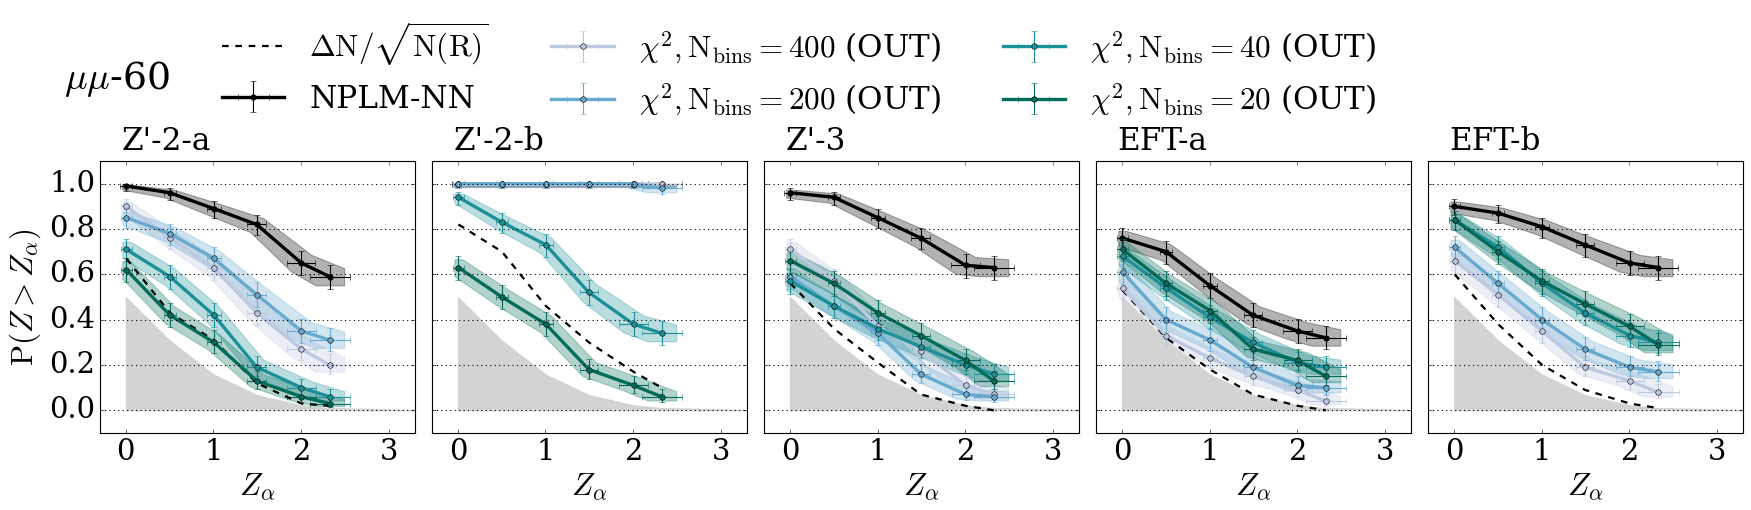

In [108]:
W = 22
H = 6
w = W/5.3
h = H/1.2
colors = ['#fff7fb','#ece2f0','#d0d1e6','#a6bddb','#67a9cf','#3690c0','#02818a','#016c59','#014636', 'black']
fig  = plt.figure(figsize=(W,H))
fig.patch.set_facecolor('white')
Z_alpha_ini = [0, 0.5, 1, 1.5, 2, 2.3, 3.5, 6.5]
Z_alpha_ini = np.array(Z_alpha_ini)
alpha_ini   = [norm.cdf(i) for i in Z_alpha_ini]

data_size = [2000, 2010, 2090, 2000, 2090, 1987]
Z_alpha_pois = np.arange(0, 2.8, 0.05)
alpha_pois = norm.cdf(Z_alpha_pois)
Pois_alpha = poisson.ppf(alpha_pois, mu=2000)
Pois_alpha_5 = poisson.ppf(1-alpha_pois, mu=2000)

labels_tests_dict = {
    #'1':['CHI2FLAT_5_IN', 'CHI2FLAT_10_IN', 'CHI2FLAT_50_IN', 'CHI2FLAT_100_IN', 'SsqrtB_tot', 'LRT'],
    '2':['LRT', 'CHI2FLAT_5_OUT', 'CHI2FLAT_10_OUT', 'CHI2FLAT_50_OUT', 'CHI2FLAT_100_OUT','SsqrtB_tot', ],
    #'3':['KSin', 'CvM_IN', 'AD_IN', 'SsqrtB_tot', 'LRT'],
    '4':['LRT', 'KSout', 'CvM_OUT', 'AD_OUT', 'SsqrtB_tot', ],
    #'5':['Moran_IN', 'RPS_IN', 'SsqrtB_tot','LRT'],
    '6':['LRT', 'Moran_OUT', 'RPS_OUT', 'SsqrtB_tot',],
    #'7':['ACC', 'AUC_ext', 'CC1', 'CC2', 'SsqrtB_tot','LRT'],
    #'8':['ACC_thr', 'CC1_thr', 'CC2_thr', 'SsqrtB_tot','LRT'],
    '9':['LRT', 'C2ST', 'SsqrtB_tot',],
    '10':['LRT', 'ACC_fixed', 'ACC', 'AUC_ext', 'SsqrtB_tot',],
    '11':['LRT_flk', 'Acc_fixed_flk', 'Acc_flk', 'AUCext_flk', 'SsqrtB_tot',],
    '12':['LRT', 'LRT_splitIN', ],
    '13':['LRT', 'LRT_splitOUT', ],
    }
color_dict ={
    #'1':['#bdc9e1','#67a9cf','#1c9099','#016c59', 'black', 'black'], 
    '2':['black', '#bdc9e1','#67a9cf','#1c9099','#016c59', 'black', ],
    #'3':['#bdc9e1','#67a9cf','#02818a', 'black', 'black'],
    '4':['black', '#bdc9e1','#67a9cf','#02818a', 'black', ],
    #'5':['#67a9cf','#02818a', 'black', 'black'],
    '6':['black', '#67a9cf','#02818a', 'black', ],
    #'7':['#bdc9e1','#67a9cf','#1c9099','#016c59', 'black', 'black'],
    #'8':['#bdc9e1','#1c9099','#016c59', 'black', 'black'],
    '9':['black', '#1c9099', 'black', ],
    '10':['black', '#bdc9e1','#67a9cf','#02818a', 'black', ],
    '11':['black', '#bdc9e1','#67a9cf','#02818a', 'black', ],
    '12':['black', '#1c9099', ],
    '13':['black', '#1c9099', ],
    }
xlabels_tests_dict  = {
    #'1': [r"$\chi^2, {\rm N_{bins}}=%i$ (IN)"%(400), r"$\chi^2, {\rm N_{bins}}=%i$ (IN)"%(200), r"$\chi^2, {\rm N_{bins}}=%i$ (IN)"%(40), r"$\chi^2, {\rm N_{bins}}=%i$ (IN)"%(20),r'${\rm \Delta N/\sqrt{N(R)}}$', 'NPLM-NN'],
    '2': ['NPLM-NN', r"$\chi^2, {\rm N_{bins}}=%i$ (OUT)"%(400), r"$\chi^2, {\rm N_{bins}}=%i$ (OUT)"%(200), r"$\chi^2, {\rm N_{bins}}=%i$ (OUT)"%(40), r"$\chi^2, {\rm N_{bins}}=%i$ (OUT)"%(20), r'${\rm \Delta N/\sqrt{N(R)}}$', ],
    #'3': ["KS (IN)", "CvM (IN)", "AD (IN)", r'${\rm \Delta N/\sqrt{N(R)}}$', "NPLM-NN"],
    '4': ['NPLM-NN', "KS (OUT)", "CvM (OUT)", "AD (OUT)", r'${\rm \Delta N/\sqrt{N(R)}}$',],
    #'5': ['Moran (IN)', 'RPS (IN)', r'${\rm \Delta N/\sqrt{N(R)}}$', 'NPLM-NN'],
    '6': ['NPLM-NN', 'Moran (OUT)', 'RPS (OUT)', r'${\rm \Delta N/\sqrt{N(R)}}$',],
    #'7': ['ACC', 'AUC', 'CC1', 'CC2', r'${\rm \Delta N/\sqrt{N(R)}}$', 'NPLM-NN'],
    #'8': ['ACC thr', 'CC1 thr', 'CC2 thr', r'${\rm \Delta N/\sqrt{N(R)}}$', 'NPLM-NN'],
    '9' : ['NPLM-NN', 'C2ST', r'${\rm \Delta N/\sqrt{N(R)}}$',],
    '10': ['NPLM-NN', r'$\rm ACC_{1/2}$-NN', r'$\rm ACC_{max}$-NN', 'AUC-NN', r'${\rm \Delta N/\sqrt{N(R)}}$', ],
    '11': ['NPLM-KM', r'$\rm ACC_{1/2}$-KM', r'$\rm ACC_{max}$-KM', 'AUC-KM', r'${\rm \Delta N/\sqrt{N(R)}}$',],
    '12': ['NPLM-NN', 'half', ],
    '13': ['NPLM-NN', 'w/ split',],
    
}  

lw=3
ms=2
version = '2'
labels_tests = labels_tests_dict[version]
color = color_dict[version] 
xlabels_tests = xlabels_tests_dict[version]
i=0
list_k = np.arange(6)#+6
for k in list_k:
    print(k)
    if k==0 or k==6: continue
    ax1 = fig.add_axes([0.06+w/W*i, 0.17*h/H, w/W*0.95, h/H*0.68])
    #ax1 = fig.add_axes([0.05+w/W*i, 0.16*h/H, w/W*0.97, h/H*0.7])
    for j in range(len(labels_tests)):
        if labels_tests[j] not in list(tests[k].keys()): continue
        t = np.array(tests[k][labels_tests[j]])
        if k<6:
            t0 = np.array(tests_0[labels_tests[j]])
            if not labels_tests[j]=='C2ST'and not 'flk' in labels_tests[j] and not 'split' in labels_tests[j]:
                t0 = t0[seeds_0>=100]
        elif k<11:
            t0 = np.array(tests_6[labels_tests[j]])
            if not labels_tests[j]=='C2ST' and not 'flk' in labels_tests[j] and not 'split' in labels_tests[j]:
                t0 = t0[seeds_6>=100]
        else:
            t0 = np.array(tests_12[labels_tests[j]])
        
        mask0 = (~np.isnan(t0))*(~np.isinf(t0))
        mask  = (~np.isnan(t))*(~np.isinf(t))
        t0, t = t0[mask0], t[mask]
        if labels_tests[j] == 'LRT': t0=t0[t0<np.max(t0)]
        if labels_tests[j] == 'MCE':
            t = t *-1
            t0= t0*-1
        if labels_tests[j] in ['ACC','ACC_fixed', 'AUC_ext', 'AUCext_flk', 'RPS_OUT'] and np.mean(t)<np.mean(t0):
            t = t *-1
            t0= t0*-1   
        if ("KS" in labels_tests[j] or "CvM" in labels_tests[j] or "CHI2" in labels_tests[j]) and np.mean(t)<np.mean(t0):
            t = t *-1
            t0= t0*-1
        thr = np.array([np.quantile(t0, alpha_i, interpolation='nearest') for alpha_i in alpha_ini])

        alpha, alpha_edw, alpha_eup, nbins = efficiency_root(t0, thr)
        power, power_edw, power_eup, nbins = efficiency_root(t, thr)
        Z_alpha   = np.array([Zscore_from_pval(alpha[i]) for i in range(nbins)])
        
        Z_alpha_eup = np.array([Zscore_from_pval(alpha[i]-alpha_edw[i])-Zscore_from_pval(alpha[i]) for i in range(len(alpha))])
        Z_alpha_edw = np.array([Zscore_from_pval(alpha[i])-Zscore_from_pval(alpha[i]+alpha_eup[i]) for i in range(len(alpha))]) 
        
        lb = xlabels_tests[j]
        zorder=2
        ls='-'
        lw=3
        ms=5
        if labels_tests[j]=='LRT': 
            zorder=1
        if labels_tests[j]=='SsqrtB_tot':
            zorder=2
            ls='--'
        x = Z_alpha[~np.isinf(Z_alpha)]
        y = power[~np.isinf(Z_alpha)]
        y_dw, y_up = power_edw[~np.isinf(Z_alpha)], power_eup[~np.isinf(Z_alpha)]
        x_dw, x_up = Z_alpha_edw[~np.isinf(Z_alpha)], Z_alpha_eup[~np.isinf(Z_alpha)]
        if labels_tests[j]=='SsqrtB_tot':
            plt.plot(x, y, color=color[j], lw=2, ls=ls, zorder=zorder, label=lb,ms=ms,)
        else:
            ax1.errorbar(x, y, 
                         yerr=[y_dw, y_up], 
                         xerr=[x_dw, x_up], 
                         marker='o', label=lb, color=color[j], lw=lw, ms=ms, ls=ls, elinewidth=1, zorder=zorder)
            x_fill,y_fill_dw, y_fill_up = np.array([]),np.array([]),np.array([])
            for a in range(len(x)):
                x_fill = np.append(x_fill, x[a]-x_dw[a]/np.sqrt(2))
                if a==0:
                    y_fill_up = np.append(y_fill_up, y[a]+y_up[a]/np.sqrt(2))
                else:
                    y_fill_up = np.append(y_fill_up, y_from_two_points(x[a]-x_dw[a]/np.sqrt(2), 
                                                                       x[a-1]+x_up[a-1]/np.sqrt(2), y[a-1]+y_up[a-1]/np.sqrt(2),
                                                                       x[a]+x_up[a]/np.sqrt(2), y[a]+y_up[a]/np.sqrt(2))  )
                y_fill_dw = np.append(y_fill_dw, y[a]-y_dw[a]/np.sqrt(2))
                ##
                x_fill = np.append(x_fill, x[a]+x_up[a]/np.sqrt(2))
                y_fill_up = np.append(y_fill_up, y[a]+y_up[a]/np.sqrt(2))
                if a<len(x)-1:
                    y_fill_dw = np.append(y_fill_dw, y_from_two_points(x[a]+x_up[a]/np.sqrt(2), 
                                                                       x[a]-x_dw[a]/np.sqrt(2), y[a]-y_dw[a]/np.sqrt(2),
                                                                       x[a+1]-x_dw[a+1]/np.sqrt(2), y[a+1]-y_dw[a+1]/np.sqrt(2)) 
                                         )
                else:
                    y_fill_dw = np.append(y_fill_dw, y[a]-y_dw[a]/np.sqrt(2))

            idx = np.argsort(x_fill)
            x_fill    = x_fill[idx]
            y_fill_dw = y_fill_dw[idx]
            y_fill_up = y_fill_up[idx]
            plt.fill_between(x_fill, y_fill_dw, y_fill_up,
                             alpha=0.3, color=color[j])
    
    ax1.fill_between(Z_alpha_ini[~np.isinf(Z_alpha_ini)], 
                    y1=np.zeros_like(Z_alpha_ini[~np.isinf(Z_alpha_ini)]), 
                    y2=1-norm.cdf(Z_alpha_ini[~np.isinf(Z_alpha_ini)]), color='lightgrey')
    plt.yticks(fontsize=26, fontname='serif')
    plt.xticks([0, 1, 2, 3], [0, 1, 2, 3], fontsize=26, fontname='serif')
    plt.ylim(-0.1,1.1)
    plt.xlim(-0.3,3.3)
    ax1.tick_params(axis='y')
    ax1.tick_params(axis='x')
    if i: ax1.tick_params(axis='y', which='both', labelleft=False)
    else: plt.ylabel(r'${\rm P}(Z>Z_{\alpha})$', fontsize=28, fontname='serif')
    plt.xlabel(r'$Z_{\alpha}$',      fontsize=28, fontname='serif')
    plt.grid(axis='y', lw=1)
    plt.text(x=-0.05, y=1.15, s=labels[k], color='black', fontsize=28, fontname='serif')
    if k==list_k[1]:
        if k<6: title = r'$\mu\mu$-60'
        else: title = r'$\mu\mu$-100'
        font = font_manager.FontProperties(family='serif', size=28) 
        ax1.legend(prop=font, loc='upper left', bbox_to_anchor=(0.3, 1.52), frameon=False,
                   ncol=len(labels_tests), 
                   numpoints=1)
        if version=='2':
            ax1.legend(prop=font, loc='upper left', bbox_to_anchor=(0.3, 1.62), frameon=False,
                   ncol=int(len(labels_tests)/2),
                   numpoints=1)
        plt.text(x=-0.7, y=1.42, s=title, fontname='serif', fontsize=34)
    for axis in ['top','bottom','left','right']:
        ax1.spines[axis].set_linewidth(1) 

    i+=1
        
fig.savefig('./5D_GOF_Mcut%i_set%s_v3.pdf'%(60*(k<6)+100*(k>6),version))
plt.show()
plt.close()

# 5D DQM

In [110]:
files = [
    '/eos/user/g/ggrosso/PhD/NOTEBOOKS/NPLM-GOF/Flk_DQM_mixture_v6.zip/ref.npy',
    '/eos/user/g/ggrosso/PhD/NOTEBOOKS/NPLM-GOF/Flk_DQM_mixture_v6.zip/ca75_05.npy',
    '/eos/user/g/ggrosso/PhD/NOTEBOOKS/NPLM-GOF/Flk_DQM_mixture_v6.zip/ca75_07.npy',
    '/eos/user/g/ggrosso/PhD/NOTEBOOKS/NPLM-GOF/Flk_DQM_mixture_v6.zip/thr75_05.npy',
    '/eos/user/g/ggrosso/PhD/NOTEBOOKS/NPLM-GOF/Flk_DQM_mixture_v6.zip/thr75_07.npy',
]

f  = np.load(files[0])
tests_0 = {}
labels_tests_all = ['LRT','acc','acc_fixed','AUCext','ks','moran','rps','cvm','ad','chi2_5','chi2_10']
#i,LRT,Acc,AUCext,KS,moran,rps,cvm,ad,chi2_5,chi2_10,time

i=0
for test in labels_tests_all:
    tests_0[test+'_flk'] = f[:, i]
    i+=1
    
tests= []
j=0
for fl in files:
    f = np.load(fl)
    print(f.shape)
    tests_j={}
    tests.append(tests_j)
    i=0
    for test in labels_tests_all:
        tests[j][test+'_flk']   = f[:, i]
        i+=1
    j+=1
    
labels = [
    r'$\rm H_0$',
    r'$\rm Ca-50$',
    r'$\rm Ca-70$',
    r'$\rm Thr-50$',
    r'$\rm Thr-70$',

]

(1000, 11)
(73, 11)
(52, 11)
(86, 11)
(61, 11)


0
1


/tmp/ipykernel_533/901529415.py:82: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  thr = np.array([np.quantile(t0, alpha_i, interpolation='nearest') for alpha_i in alpha_ini])
/tmp/ipykernel_533/744294864.py:40: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  pEff.Fill(bPassed,thr[j])
/tmp/ipykernel_533/901529415.py:86: RuntimeWarning: invalid value encountered in double_scalars
  Z_alpha_eup = np.array([Zscore_from_pval(alpha[i]-alpha_edw[i])-Zscore_from_pval(alpha[i]) for i in range(len(alpha))])


2


/tmp/ipykernel_533/901529415.py:82: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  thr = np.array([np.quantile(t0, alpha_i, interpolation='nearest') for alpha_i in alpha_ini])
/tmp/ipykernel_533/744294864.py:40: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  pEff.Fill(bPassed,thr[j])
/tmp/ipykernel_533/901529415.py:86: RuntimeWarning: invalid value encountered in double_scalars
  Z_alpha_eup = np.array([Zscore_from_pval(alpha[i]-alpha_edw[i])-Zscore_from_pval(alpha[i]) for i in range(len(alpha))])


3


/tmp/ipykernel_533/901529415.py:82: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  thr = np.array([np.quantile(t0, alpha_i, interpolation='nearest') for alpha_i in alpha_ini])
/tmp/ipykernel_533/744294864.py:40: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  pEff.Fill(bPassed,thr[j])
/tmp/ipykernel_533/901529415.py:86: RuntimeWarning: invalid value encountered in double_scalars
  Z_alpha_eup = np.array([Zscore_from_pval(alpha[i]-alpha_edw[i])-Zscore_from_pval(alpha[i]) for i in range(len(alpha))])


4


/tmp/ipykernel_533/901529415.py:82: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  thr = np.array([np.quantile(t0, alpha_i, interpolation='nearest') for alpha_i in alpha_ini])
/tmp/ipykernel_533/744294864.py:40: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  pEff.Fill(bPassed,thr[j])
/tmp/ipykernel_533/901529415.py:86: RuntimeWarning: invalid value encountered in double_scalars
  Z_alpha_eup = np.array([Zscore_from_pval(alpha[i]-alpha_edw[i])-Zscore_from_pval(alpha[i]) for i in range(len(alpha))])


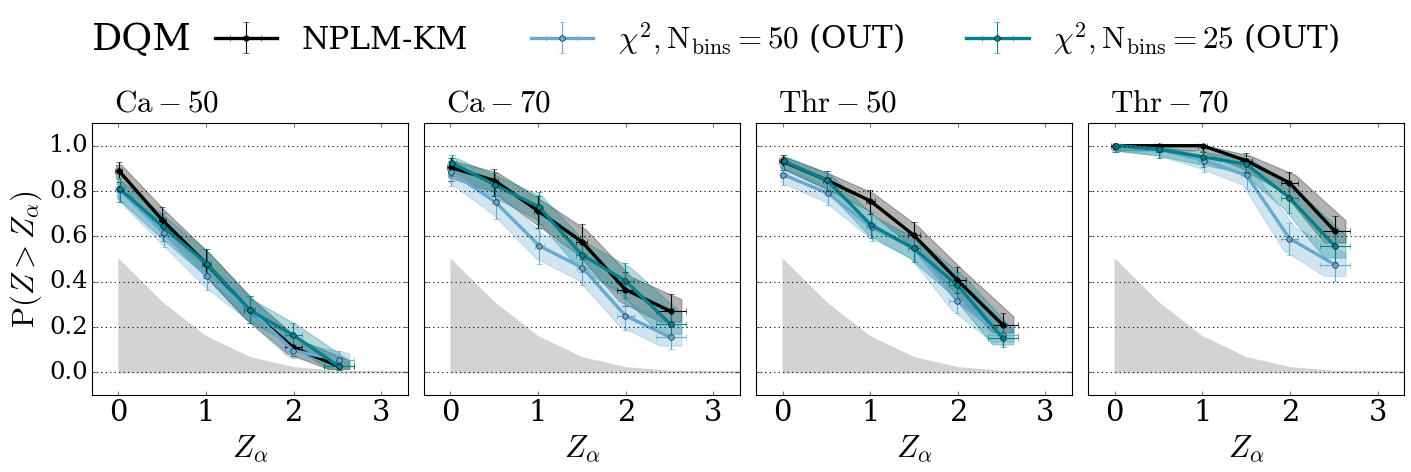

In [120]:
W = 22
H = 6
w = W/5.3
h = H/1.2
colors = ['#fff7fb','#ece2f0','#d0d1e6','#a6bddb','#67a9cf','#3690c0','#02818a','#016c59','#014636', 'black']
fig  = plt.figure(figsize=(W,H))
fig.patch.set_facecolor('white')
Z_alpha_ini = [0, 0.5, 1, 1.5, 2, 2.5,5.5, 6.5]
Z_alpha_ini = np.array(Z_alpha_ini)
alpha_ini   = [norm.cdf(i) for i in Z_alpha_ini]

labels_tests_dict = {
    #'1':['CHI2FLAT_5_IN', 'CHI2FLAT_10_IN', 'CHI2FLAT_50_IN', 'CHI2FLAT_100_IN', 'SsqrtB_tot', 'LRT'],
    '2':['LRT_flk', 'chi2_5_flk', 'chi2_10_flk', ],
    #'3':['KSin', 'CvM_IN', 'AD_IN', 'SsqrtB_tot', 'LRT'],
    '4':['LRT_flk', 'ks_flk', 'cvm_flk', 'ad_flk', ],
    #'5':['Moran_IN', 'RPS_IN', 'SsqrtB_tot','LRT'],
    '6':['LRT_flk', 'moran_flk', 'rps_flk', ],
    #'7':['ACC', 'AUC_ext', 'CC1', 'CC2', 'SsqrtB_tot','LRT'],
    #'8':['ACC_thr', 'CC1_thr', 'CC2_thr', 'SsqrtB_tot','LRT'],
    #'9':['C2ST', 'SsqrtB_tot','LRT'],
    #'10': ['ACC', 'AUC_ext', 'SsqrtB_tot','LRT'],
    '11': ['LRT_flk', 'acc_fixed_flk', 'acc_flk', 'AUCext_flk',],
    }
color_dict ={
    #'1':['#bdc9e1','#67a9cf','#1c9099','#016c59', 'black', 'black'], 
    '2':['black', '#67a9cf','#02818a', ],
    #'3':['#bdc9e1','#67a9cf','#02818a', 'black', 'black'],
    '4':['black', '#bdc9e1','#67a9cf','#02818a', ],
    #'5':['#67a9cf','#02818a', 'black', 'black'],
    '6':['black', '#67a9cf','#02818a', ],
    #'7':['#bdc9e1','#67a9cf','#1c9099','#016c59', 'black', 'black'],
    #'8':['#bdc9e1','#1c9099','#016c59', 'black', 'black'],
    #'9':['#1c9099', 'black', 'black'],
    #'10':['#67a9cf','#02818a', 'black', 'black'],
    '11':['black', '#bdc9e1','#1c9099','#016c59', ],
    }
xlabels_tests_dict  = {
    #'1': [r"$\chi^2, {\rm N_{bins}}=%i$ (IN)"%(400), r"$\chi^2, {\rm N_{bins}}=%i$ (IN)"%(200), r"$\chi^2, {\rm N_{bins}}=%i$ (IN)"%(40), r"$\chi^2, {\rm N_{bins}}=%i$ (IN)"%(20),r'${\rm \Delta N/\sqrt{N(R)}}$', 'NPLM-KM'],
    '2': ['NPLM-KM', r"$\chi^2, {\rm N_{bins}}=%i$ (OUT)"%(50), r"$\chi^2, {\rm N_{bins}}=%i$ (OUT)"%(25), ],
    #'3': ["KS (IN)", "CvM (IN)", "AD (IN)", r'${\rm \Delta N/\sqrt{N(R)}}$', "NPLM-KM"],
    '4': ['NPLM-KM', "KS (OUT)", "CvM (OUT)", "AD (OUT)", ],
    #'5': ['Moran (IN)', 'RPS (IN)', r'${\rm \Delta N/\sqrt{N(R)}}$', 'NPLM-KM'],
    '6': ['NPLM-KM', 'Moran (OUT)', 'RPS (OUT)', ],
    #'7': ['ACC', 'AUC', 'CC1', 'CC2', r'${\rm \Delta N/\sqrt{N(R)}}$', 'NPLM-NN'],
    #'8': ['ACC thr', 'CC1 thr', 'CC2 thr', r'${\rm \Delta N/\sqrt{N(R)}}$', 'NPLM-NN'],
    #'9': ['C2ST', r'${\rm \Delta N/\sqrt{N(R)}}$', 'NPLM-KM'],
    #'10': ['ACC-NN', 'AUC-NN', r'${\rm \Delta N/\sqrt{N(R)}}$', 'NPLM-NN'],
    '11': ['NPLM-KM', r'$\rm ACC_{1/2}$-KM', r'$\rm ACC_{max}$-KM', 'AUC-KM', ],
}  


lw=3
ms=2
version = '2'
labels_tests = labels_tests_dict[version]
color = color_dict[version] 
xlabels_tests = xlabels_tests_dict[version]
i=0
list_k = np.arange(5)
for k in list_k:
    print(k)
    if k==0: continue
    ax1 = fig.add_axes([0.06+w/W*i, 0.17*h/H, w/W*0.95, h/H*0.68])
    for j in range(len(labels_tests)):
        if labels_tests[j] not in list(tests[k].keys()): continue
        t = np.array(tests[k][labels_tests[j]])
        t0= np.array(tests[0][labels_tests[j]])
        mask0 = (~np.isnan(t0))*(~np.isinf(t0))
        mask  = (~np.isnan(t))*(~np.isinf(t))
        t0, t = t0[mask0], t[mask]
        if labels_tests[j] == 'LRT': t0=t0[t0<np.max(t0)]
        if labels_tests[j] == 'MCE':
            t = t *-1
            t0= t0*-1
        if labels_tests[j] in ['ad_flk','acc', 'AUCext_flk', 'rps_flk'] and np.mean(t)<np.mean(t0):
            t = t *-1
            t0= t0*-1   
        if ("KS" in labels_tests[j] or "CvM" in labels_tests[j] or "CHI2" in labels_tests[j]) and np.mean(t)<np.mean(t0):
            t = t *-1
            t0= t0*-1
        thr = np.array([np.quantile(t0, alpha_i, interpolation='nearest') for alpha_i in alpha_ini])
        alpha, alpha_edw, alpha_eup, nbins = efficiency_root(t0, thr)
        power, power_edw, power_eup, nbins = efficiency_root(t, thr)
        Z_alpha     = np.array([Zscore_from_pval(alpha[i]) for i in range(nbins)])
        Z_alpha_eup = np.array([Zscore_from_pval(alpha[i]-alpha_edw[i])-Zscore_from_pval(alpha[i]) for i in range(len(alpha))])
        Z_alpha_edw = np.array([Zscore_from_pval(alpha[i])-Zscore_from_pval(alpha[i]+alpha_eup[i]) for i in range(len(alpha))]) 
        lb = xlabels_tests[j]
        zorder=2
        ls='-'
        ms=5
        if labels_tests[j]=='LRT': 
            zorder=1
            lw=3
            ms=5
            
        if labels_tests[j]=='SsqrtB_tot':
            zorder=2
            lw=3
            ms=5
            ls='--'
        x = Z_alpha[~np.isinf(Z_alpha)]
        y = power[~np.isinf(Z_alpha)]
        y_dw, y_up = power_edw[~np.isinf(Z_alpha)], power_eup[~np.isinf(Z_alpha)]
        x_dw, x_up = Z_alpha_edw[~np.isinf(Z_alpha)], Z_alpha_eup[~np.isinf(Z_alpha)]
        if labels_tests[j]=='SsqrtB_tot':
            plt.plot(x, y, color=color[j], lw=lw, ls=ls, zorder=zorder, label=lb,ms=ms,)
        else:
            ax1.errorbar(x, y, 
                         yerr=[y_dw, y_up], 
                         xerr=[x_dw, x_up], 
                         marker='o', label=lb, color=color[j], lw=lw, ms=ms, ls=ls, elinewidth=1, zorder=zorder)
            
            x_fill,y_fill_dw, y_fill_up = np.array([]),np.array([]),np.array([])
            for a in range(len(x)):
                x_fill = np.append(x_fill, x[a]-x_dw[a]/np.sqrt(2))
                if a==0:
                    y_fill_up = np.append(y_fill_up, y[a]+y_up[a]/np.sqrt(2))
                else:
                    y_fill_up = np.append(y_fill_up, y_from_two_points(x[a]-x_dw[a]/np.sqrt(2), 
                                                                       x[a-1]+x_up[a-1]/np.sqrt(2), y[a-1]+y_up[a-1]/np.sqrt(2),
                                                                       x[a]+x_up[a]/np.sqrt(2), y[a]+y_up[a]/np.sqrt(2)) 
                                         )

                y_fill_dw = np.append(y_fill_dw, y[a]-y_dw[a]/np.sqrt(2))
                ##
                x_fill = np.append(x_fill, x[a]+x_up[a]/np.sqrt(2))
                y_fill_up = np.append(y_fill_up, y[a]+y_up[a]/np.sqrt(2))
                if a<len(x)-1:
                    y_fill_dw = np.append(y_fill_dw, y_from_two_points(x[a]+x_up[a]/np.sqrt(2), 
                                                                       x[a]-x_dw[a]/np.sqrt(2), y[a]-y_dw[a]/np.sqrt(2),
                                                                       x[a+1]-x_dw[a+1]/np.sqrt(2), y[a+1]-y_dw[a+1]/np.sqrt(2)) 
                                         )
                else:
                    y_fill_dw = np.append(y_fill_dw, y[a]-y_dw[a]/np.sqrt(2))

            idx = np.argsort(x_fill)
            x_fill    = x_fill[idx]
            y_fill_dw = y_fill_dw[idx]
            y_fill_up = y_fill_up[idx]
            plt.fill_between(x_fill, y_fill_dw, y_fill_up,
                             alpha=0.3, color=color[j])
    
    ax1.fill_between(Z_alpha_ini[~np.isinf(Z_alpha_ini)], 
                    y1=np.zeros_like(Z_alpha_ini[~np.isinf(Z_alpha_ini)]), 
                    y2=1-norm.cdf(Z_alpha_ini[~np.isinf(Z_alpha_ini)]), color='lightgrey')
    plt.yticks(fontsize=22, fontname='serif')
    plt.xticks([0, 1, 2, 3], [0, 1, 2, 3], fontsize=26, fontname='serif')
    plt.ylim(-0.1,1.1)
    plt.xlim(-0.3,3.3)
    ax1.tick_params(axis='y')
    ax1.tick_params(axis='x')
    if i: ax1.tick_params(axis='y', which='both', labelleft=False)
    else: plt.ylabel(r'${\rm P}(Z>Z_{\alpha})$', fontsize=28, fontname='serif')
    plt.xlabel(r'$Z_{\alpha}$',      fontsize=28, fontname='serif')
    plt.grid(axis='y', lw=1)
    plt.text(x=-0.05, y=1.15,s=labels[k],color='black', fontsize=28)
    if k==list_k[1]:
        font = font_manager.FontProperties(family='serif', size=28) 
        ax1.legend(prop=font, loc='upper left', bbox_to_anchor=(0.3, 1.48), frameon=False,
                   ncol=len(labels_tests), numpoints=1)
        plt.text(x=-0.3, y=1.42, s="DQM", fontname='serif', fontsize=34)
    for axis in ['top','bottom','left','right']:
        ax1.spines[axis].set_linewidth(1) 

    i+=1
fig.savefig('./5D-DQMmix_GOF_set%s_v5.pdf'%(version))
plt.show()
plt.close()

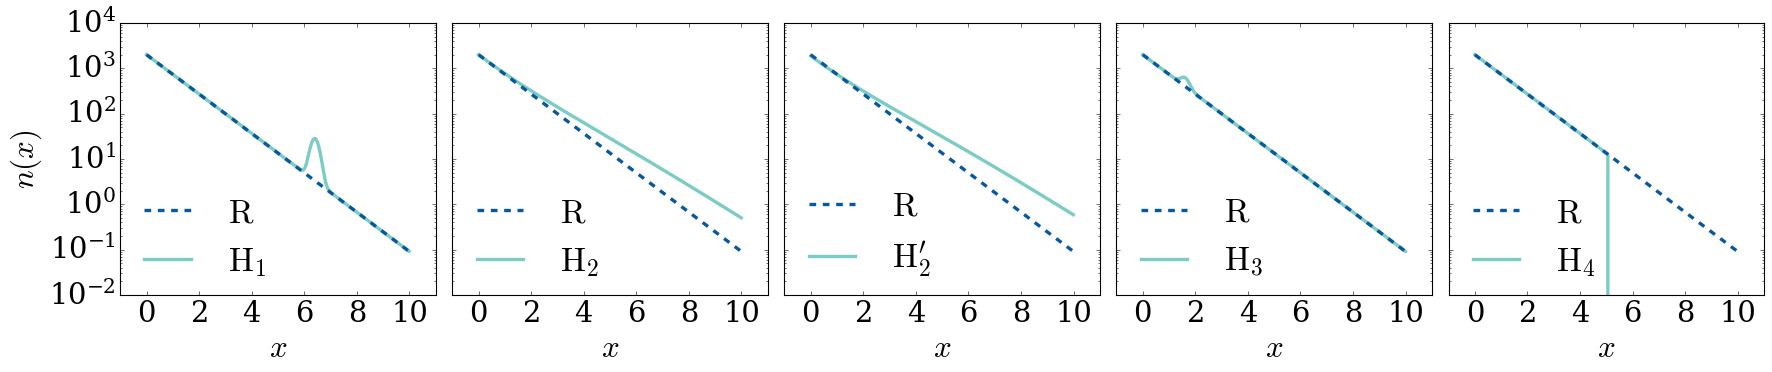

In [103]:
colors = [#'#f7fcf0','#e0f3db',
          '#ccebc5','#a8ddb5','#7bccc4','#4eb3d3','#2b8cbe','#08589e']

W = 22
H = 6
w = W/5.3
h = H/1.2

plt.rcParams["font.family"] = "serif"
plt.style.use('classic')
fig = plt.figure(figsize=(W, H))                                                                                                                                            
fig.patch.set_facecolor('white')
#ax=fig.add_axes([0.07, 0.2, 0.18, 0.7])
i=0
ax= fig.add_axes([0.06+w/W*i, 0.17*h/H, w/W*0.95, h/H*0.68])
x = np.arange(0, 10, 0.01)
plt.plot(x,2000*expon.pdf(x), label=r'$\rm R$', color=colors[-1], lw=3, ls='--', zorder=2)
plt.plot(x,2000*expon.pdf(x)+10*norm.pdf(x, loc=6.4, scale=0.16), label=r'$\rm H_1$', color=colors[2], lw=3, zorder=1)
plt.yscale('log')
font = font_manager.FontProperties(family='serif', size=30) #weight='bold', style='normal', )
plt.legend(ncol=1, loc='lower left', bbox_to_anchor=(-0.05, -0.05), prop=font, frameon=False)
plt.xlabel(r'$x$', fontsize=28, fontname="serif")
plt.ylabel(r'$n(x)$', fontsize=28, fontname="serif")
plt.yticks(fontsize=26, fontname="serif")
plt.xticks(fontsize=26, fontname="serif")
plt.xlim(-1, 11)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1)

#ax=fig.add_axes([0.07+0.18, 0.2, 0.18, 0.7])
i=1
ax= fig.add_axes([0.06+w/W*i, 0.17*h/H, w/W*0.95, h/H*0.68])
x = np.arange(0, 10, 0.01)
plt.plot(x,2000*expon.pdf(x), label=r'$\rm R$', color=colors[-1], lw=3, ls='--', zorder=2)
plt.plot(x,2000*expon.pdf(x)+90*x*x*expon.pdf(x), label=r'$\rm H_2$', color=colors[2], lw=3, zorder=1)
plt.yscale('log')
font = font_manager.FontProperties(family='serif', size=30) #weight='bold', style='normal', )
plt.legend(ncol=1, loc='lower left', bbox_to_anchor=(-0.05, -0.05), prop=font, frameon=False)
plt.xlabel(r'$x$', fontsize=28, fontname="serif")
plt.yticks(fontsize=26, fontname="serif")
plt.xticks(fontsize=26, fontname="serif")
plt.xlim(-1, 11)
ax.tick_params(axis='y', which='both', labelleft=False)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1)
    
#ax=fig.add_axes([0.07+2*0.18, 0.2, 0.18, 0.7])
i=2
ax= fig.add_axes([0.06+w/W*i, 0.17*h/H, w/W*0.95, h/H*0.68])
x = np.arange(0, 10, 0.01)
plt.plot(x,2000*expon.pdf(x), label=r'$\rm R$', color=colors[-1], lw=3, ls='--', zorder=2)
plt.plot(x,1890*expon.pdf(x)+110*x*x*expon.pdf(x), label=r"$\rm H_2'$", color=colors[2], lw=3, zorder=1)
plt.yscale('log')
font = font_manager.FontProperties(family='serif', size=30) #weight='bold', style='normal', )
plt.legend(ncol=1, loc='lower left', bbox_to_anchor=(-0.05, -0.05), prop=font, frameon=False)
plt.xlabel(r'$x$', fontsize=28, fontname="serif")
plt.yticks(fontsize=26, fontname="serif")
plt.xticks(fontsize=26, fontname="serif")
plt.xlim(-1, 11)
ax.tick_params(axis='y', which='both', labelleft=False)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1)


#ax=fig.add_axes([0.07+3*0.18, 0.2, 0.18, 0.7])
i=3
ax= fig.add_axes([0.06+w/W*i, 0.17*h/H, w/W*0.95, h/H*0.68])
x = np.arange(0, 10, 0.01)
plt.plot(x,2000*expon.pdf(x), label=r'$\rm R$', color=colors[-1], lw=3, ls='--', zorder=2)
plt.plot(x,2000*expon.pdf(x)+90*norm.pdf(x, loc=1.6, scale=0.16), label=r'$\rm H_3$', color=colors[2], lw=3, zorder=1)
plt.yscale('log')
font = font_manager.FontProperties(family='serif', size=30) #weight='bold', style='normal', )
plt.legend(ncol=1, loc='lower left', bbox_to_anchor=(-0.05, -0.05), prop=font, frameon=False)
plt.xlabel(r'$x$', fontsize=28, fontname="serif")
plt.yticks(fontsize=26, fontname="serif")
plt.xticks(fontsize=26, fontname="serif")
plt.xlim(-1, 11)
ax.tick_params(axis='y', which='both', labelleft=False)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1)

#ax=fig.add_axes([0.07+4*0.18, 0.2, 0.18, 0.7])
i=4
ax= fig.add_axes([0.06+w/W*i, 0.17*h/H, w/W*0.95, h/H*0.68])
x = np.arange(0, 10, 0.01)
plt.plot(x,2000*expon.pdf(x), label=r'$\rm R$', color=colors[-1], lw=3, ls='--', zorder=2)
plt.plot(x,2000*expon.pdf(x)*(x<5.07)+0*x*(x>5.07), label=r'$\rm H_4$', color=colors[2], lw=3, zorder=1)
plt.yscale('log')
font = font_manager.FontProperties(family='serif', size=30) #weight='bold', style='normal', )
plt.legend(ncol=1, loc='lower left', bbox_to_anchor=(-0.05, -0.05), prop=font, frameon=False)
plt.xlabel(r'$x$', fontsize=28, fontname="serif")
plt.yticks(fontsize=26, fontname="serif")
plt.xticks(fontsize=26, fontname="serif")
plt.xlim(-1, 11)
ax.tick_params(axis='y', which='both', labelleft=False)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1)
plt.savefig('./1Dexpo_NPLM_gof_data_v2.pdf')
plt.show()
plt.close()